# test 1

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Set the data directory
data_dir = 'archive (1)/ts/ts/'

# Load the images and bounding box coordinates
images = []
boxes = []
classes = []
class_map = {'prohibitory': 0, 'danger': 1, 'mandatory': 2, 'other': 3}

for filename in os.listdir(data_dir):
    if filename.endswith('.jpg'):
        img = cv2.imread(os.path.join(data_dir, filename))
        images.append(img)

        txt_file = os.path.join(data_dir, filename.replace('.jpg', '.txt'))
        with open(txt_file, 'r') as f:
            line = f.readline().strip().split()
            class_id = int(line[0])
            x, y, w, h = map(float, line[1:])
            boxes.append([x, y, w, h])
            classes.append(class_map[['prohibitory', 'danger', 'mandatory', 'other'][class_id]])

# Split the data into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(images, boxes, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

/Users/abdul/Documents/GitHub/css2-repo/env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/abdul/Documents/GitHub/css2-repo/env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/abdul/Documents/GitHub/css2-repo/env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/abdul/Documents/GitHub/css2-repo/env/

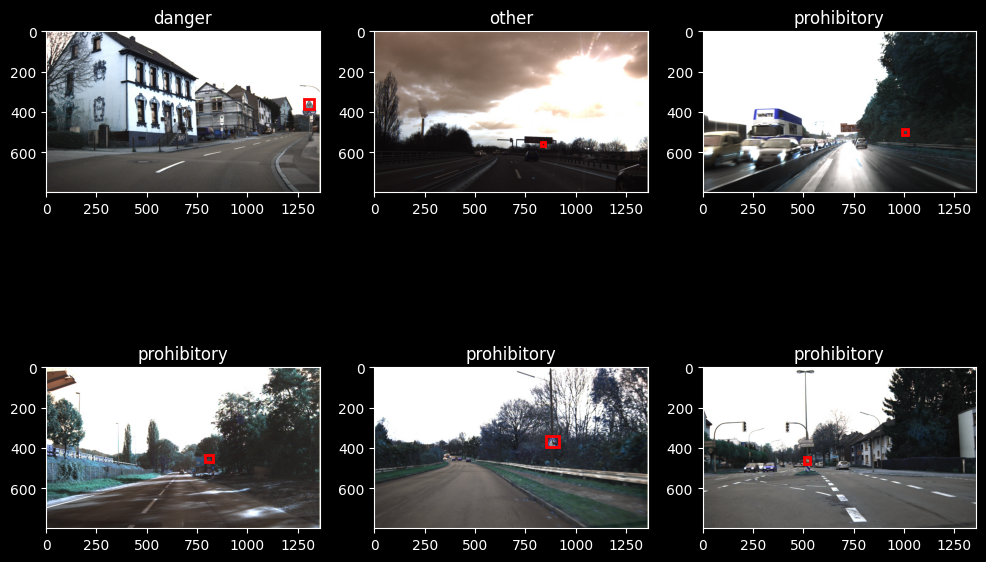

In [2]:
import matplotlib.pyplot as plt

# Visualize a few examples
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
for i, ax in enumerate(axs.flat):
    img = X_train[i]
    box = y_train[i]
    x, y, w, h = box
    x1, y1, x2, y2 = int((x - w/2) * img.shape[1]), int((y - h/2) * img.shape[0]), \
                    int((x + w/2) * img.shape[1]), int((y + h/2) * img.shape[0])
    ax.imshow(img)
    ax.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2))
    ax.set_title(list(class_map.keys())[list(class_map.values()).index(classes[i])])
plt.show()

In [8]:
import numpy as np
import cv2

def preprocess_data(X_train, X_val, y_train, y_val, image_size=(416, 416)):
    """
    Preprocess the data for the YOLOv2 model.

    Args:
        X_train (list): List of training images.
        X_val (list): List of validation images.
        y_train (list): List of training bounding box coordinates.
        y_val (list): List of validation bounding box coordinates.
        image_size (tuple): Desired image size for the YOLOv2 model (default: (416, 416)).

    Returns:
        Tuple: Preprocessed training and validation data.
    """
    # Resize the images
    X_train_resized = [cv2.resize(img, image_size) for img in X_train]
    X_val_resized = [cv2.resize(img, image_size) for img in X_val]

    # Normalize the pixel values
    X_train_norm = np.array([img / 255.0 for img in X_train_resized])
    X_val_norm = np.array([img / 255.0 for img in X_val_resized])

    # Convert bounding box coordinates to absolute values
    image_width, image_height = image_size
    y_train_abs = []
    for box in y_train:
        x, y, w, h = box
        x_abs = x * image_width
        y_abs = y * image_height
        w_abs = w * image_width
        h_abs = h * image_height
        y_train_abs.append([x_abs, y_abs, w_abs, h_abs])

    y_val_abs = []
    for box in y_val:
        x, y, w, h = box
        x_abs = x * image_width
        y_abs = y * image_height
        w_abs = w * image_width
        h_abs = h * image_height
        y_val_abs.append([x_abs, y_abs, w_abs, h_abs])

    # Create the ground truth labels
    grid_size = 13
    num_classes = 4
    y_train_yolo = create_ground_truth(y_train_abs, grid_size, num_classes)
    y_val_yolo = create_ground_truth(y_val_abs, grid_size, num_classes)

    return X_train_norm, X_val_norm, y_train_yolo, y_val_yolo

def create_ground_truth(boxes, grid_size, num_classes):
    """
    Create the ground truth labels in the format required by YOLOv2.

    Args:
        boxes (list): List of bounding box coordinates.
        grid_size (int): Grid size of the YOLOv2 model.
        num_classes (int): Number of classes in the dataset.

    Returns:
        numpy.ndarray: Ground truth labels in the format required by YOLOv2.
    """
    ground_truth = np.zeros((grid_size, grid_size, 5 + num_classes))

    for box in boxes:
        x, y, w, h = box
        grid_x = int(x // (image_width / grid_size))
        grid_y = int(y // (image_height / grid_size))

        ground_truth[grid_y, grid_x, 0] = x - grid_x * (image_width / grid_size)
        ground_truth[grid_y, grid_x, 1] = y - grid_y * (image_height / grid_size)
        ground_truth[grid_y, grid_x, 2] = w
        ground_truth[grid_y, grid_x, 3] = h
        ground_truth[grid_y, grid_x, 4] = 1  # Objectness score
        # Set the class probabilities
        ground_truth[grid_y, grid_x, 5 + class_id] = 1

    return ground_truth

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

# Preprocess the data
X_train, X_val, y_train, y_val = preprocess_data(X_train, X_val, y_train, y_val)

# Define the YOLOv2 model
model = Sequential()
# Add convolutional and pooling layers
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(416, 416, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add more convolutional and pooling layers
# Add the detection head
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5 + num_classes, activation='linear'))

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='mse')

# Train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

NameError: name 'image_width' is not defined

In [ ]:
from sklearn.metrics import precision_score, recall_score, average_precision_score

# Evaluate the model on the test set
y_pred = model.predict(np.array(X_test))

# Calculate the metrics
ious = []
precisions = []
recalls = []
aps = []

for class_id in range(len(class_map)):
    class_idx = np.where(np.array(classes) == class_id)[0]
    class_boxes_test = [y_test[i] for i in class_idx]
    class_boxes_pred = y_pred[class_idx, :4]

    # Calculate IoU, Precision, Recall, and AP for the current class
    iou = calculate_iou(class_boxes_test, class_boxes_pred)
    precision = precision_score(np.ones_like(class_idx), np.array([1 if iou > 0.5 else 0 for iou in iou]))
    recall = recall_score(np.ones_like(class_idx), np.array([1 if iou > 0.5 else 0 for iou in iou]))
    ap = average_precision_score(np.ones_like(class_idx), np.array([iou for iou in iou]))

    ious.append(np.mean(iou))
    precisions.append(precision)
    recalls.append(recall)
    aps.append(ap)

print("Class\tAvg. IoU\tPrecision\tRecall\tAP")
for class_name, iou, precision, recall, ap in zip(class_map.keys(), ious, precisions, recalls, aps):
    print(f"{class_name}\t{iou:.4f}\t{precision:.4f}\t{recall:.4f}\t{ap:.4f}")

# test 

In [40]:
import os
import cv2

def resize_image(image, target_size):
    height, width = image.shape[:2]
    new_width = target_size[0]
    new_height = target_size[1]
    resized_image = cv2.resize(image, (new_width, new_height))
    return resized_image, new_width, new_height

def update_bounding_box(txt_file, original_size, new_size):
    original_width, original_height = original_size
    new_width, new_height = new_size
    with open(txt_file, 'r') as file:
        lines = file.readlines()
    updated_lines = []
    for line in lines:
        data = line.strip().split()
        class_id = data[0]
        x_center = float(data[1])
        y_center = float(data[2])
        width = float(data[3])
        height = float(data[4])
        new_x_center = (x_center * original_width) * (new_width / original_width) / new_width
        new_y_center = (y_center * original_height) * (new_height / original_height) / new_height
        new_width = (width * original_width) * (new_width / original_width) / new_width
        new_height = (height * original_height) * (new_height / original_height) / new_height
        updated_line = f"{class_id} {new_x_center:.6f} {new_y_center:.6f} {new_width:.6f} {new_height:.6f}\n"
        updated_lines.append(updated_line)
    with open(txt_file, 'w') as file:
        file.writelines(updated_lines)

def process_folder(folder_path, target_size, original_size):
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            resized_image, new_width, new_height = resize_image(image, target_size)
            cv2.imwrite(image_path, resized_image)
            txt_file = os.path.splitext(image_path)[0] + '.txt'
            update_bounding_box(txt_file, original_size, (new_width, new_height))

# Set the target size (divisible by 32) and original size
target_size = (800, 480)  # Adjust the dimensions as needed
original_size = (1360, 800)

# Process images and bounding boxes in the train folder
train_folder = 'darknet/3_class_data/data/train'
process_folder(train_folder, target_size, original_size)

# Process images and bounding boxes in the test folder
test_folder = 'darknet/3_class_data/data/test'
process_folder(test_folder, target_size, original_size)

# Process images and bounding boxes in the val folder
val_folder = 'darknet/3_class_data/data/val'
process_folder(val_folder, target_size, original_size)

print("Image resizing and bounding box updating completed.")

Image resizing and bounding box updating completed.


In [39]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Set the data directory
data_dir = 'darknet/3_class_data/ts/ts'

# Load the images and bounding box coordinates
images = []
boxes = []
classes = []
class_map = {'prohibitory': 0, 'danger': 1, 'mandatory': 2, 'other': 3}

for filename in os.listdir(data_dir):
    if filename.endswith('.jpg'):
        img = cv2.imread(os.path.join(data_dir, filename))
        images.append(img)
        
        txt_file = os.path.join(data_dir, filename.replace('.jpg', '.txt'))
        with open(txt_file, 'r') as f:
            line = f.readline().strip().split()
            class_id = int(line[0])
            x, y, w, h = map(float, line[1:])
            boxes.append([x, y, w, h])
            classes.append(class_map[['prohibitory', 'danger', 'mandatory', 'other'][class_id]])

# Split the data into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(images, boxes, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create the necessary directories
os.makedirs('3_class_data/data/train', exist_ok=True)
os.makedirs('3_class_data/data/test', exist_ok=True)
os.makedirs('3_class_data/data/val', exist_ok=True)
os.makedirs('3_class_data/data/backup', exist_ok=True)

# Save the images and labels to the respective directories
def save_data(data, labels, directory):
    for i, (image, box) in enumerate(zip(data, labels)):
        filename = f"{directory}/{i}.jpg"
        cv2.imwrite(filename, image)
        
        with open(filename.replace('.jpg', '.txt'), 'w') as f:
            class_id = classes[i]
            x, y, w, h = box
            f.write(f"{class_id} {x} {y} {w} {h}\n")

save_data(X_train, y_train, 'darknet/3_class_data/data/train')
save_data(X_test, y_test, 'darknet/3_class_data/data/test')
save_data(X_val, y_val, 'darknet/3_class_data/data/val')

# Create the obj.data file
with open('darknet/3_class_data/data/obj.data', 'w') as f:
    f.write('classes = 4\n')
    f.write('train = darknet/3_class_data/data/train.txt\n')
    f.write('valid = darknet/3_class_data/data/val.txt\n')
    f.write('names = darknet/3_class_data/data/obj.names\n')
    f.write('backup = darknet/3_class_data/data/backup/\n')

# Create the obj.names file
with open('darknet/3_class_data/data/obj.names', 'w') as f:
    f.write('prohibitory\n')
    f.write('danger\n')
    f.write('mandatory\n')
    f.write('other\n')

# Create the train.txt and val.txt files
with open('darknet/3_class_data/data/train.txt', 'w') as f:
    for filename in os.listdir('darknet/3_class_data/data/train'):
        if filename.endswith('.jpg'):
            f.write(f"/Users/abdul/Documents/GitHub/css2-repo/darknet/3_class_data/data/train/{filename}\n")

with open('darknet/3_class_data/data/val.txt', 'w') as f:
    for filename in os.listdir('darknet/3_class_data/data/val'):
        if filename.endswith('.jpg'):
            f.write(f"/Users/abdul/Documents/GitHub/css2-repo/darknet/3_class_data/data/val/{filename}\n")

print("Dataset preparation completed.")

Dataset preparation completed.


In [36]:
import os
import cv2

def resize_image(image, target_size):
    height, width = image.shape[:2]
    aspect_ratio = width / height

    if aspect_ratio > 1:
        new_width = target_size
        new_height = int(target_size / aspect_ratio)
    else:
        new_height = target_size
        new_width = int(target_size * aspect_ratio)

    resized_image = cv2.resize(image, (new_width, new_height))
    return resized_image, new_width, new_height

def update_bounding_box(txt_file, original_size, new_size):
    original_width, original_height = original_size
    new_width, new_height = new_size

    with open(txt_file, 'r') as file:
        lines = file.readlines()

    updated_lines = []
    for line in lines:
        data = line.strip().split()
        class_id = data[0]
        x_center = float(data[1])
        y_center = float(data[2])
        width = float(data[3])
        height = float(data[4])

        new_x_center = (x_center * original_width) * (new_width / original_width) / new_width
        new_y_center = (y_center * original_height) * (new_height / original_height) / new_height
        new_width = (width * original_width) * (new_width / original_width) / new_width
        new_height = (height * original_height) * (new_height / original_height) / new_height

        updated_line = f"{class_id} {new_x_center:.6f} {new_y_center:.6f} {new_width:.6f} {new_height:.6f}\n"
        updated_lines.append(updated_line)

    with open(txt_file, 'w') as file:
        file.writelines(updated_lines)

def process_folder(folder_path, target_size, original_size):
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            resized_image, new_width, new_height = resize_image(image, target_size)
            cv2.imwrite(image_path, resized_image)

            txt_file = os.path.splitext(image_path)[0] + '.txt'
            update_bounding_box(txt_file, original_size, (new_width, new_height))

# Set the target size and original size
target_size = 800
original_size = (1360, 800)

# Process images and bounding boxes in the train folder
train_folder = 'darknet/3_class_data/data/train'
process_folder(train_folder, target_size, original_size)

# Process images and bounding boxes in the test folder
test_folder = 'darknet/3_class_data/data/test'
process_folder(test_folder, target_size, original_size)

# Process images and bounding boxes in the val folder
val_folder = 'darknet/3_class_data/data/val'
process_folder(val_folder, target_size, original_size)

print("Image resizing and bounding box updating completed.")

Image resizing and bounding box updating completed.


In [4]:
import os
import cv2

def visualize_bounding_boxes(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(folder_path, filename)
            txt_path = os.path.join(folder_path, filename.split('.')[0] + '.txt')

            image = cv2.imread(image_path)
            height, width, _ = image.shape

            with open(txt_path, 'r') as file:
                lines = file.readlines()

            for line in lines:
                data = line.strip().split()
                class_id = int(data[0])
                x_center = float(data[1])
                y_center = float(data[2])
                bbox_width = float(data[3])
                bbox_height = float(data[4])

                # Calculate bounding box coordinates
                x_min = int((x_center - bbox_width / 2) * width)
                y_min = int((y_center - bbox_height / 2) * height)
                x_max = int((x_center + bbox_width / 2) * width)
                y_max = int((y_center + bbox_height / 2) * height)

                # Draw bounding box on the image
                cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                print(f"Image: {filename}")
                print(f"Bounding Box: ({x_min}, {y_min}), ({x_max}, {y_max})")

            cv2.imshow('Image with Bounding Boxes', image)
            # cv2.waitKey(0)
            
            # cv2.destroyAllWindows()
            if cv2.waitKey(0) & 0xFF == 27:  # 27 is the ASCII code for the ESC key
                cv2.destroyAllWindows()
                break  # Break the loop or return to exit the function early


In [2]:
# import os

# # Set the path to the directory containing the train and val folders
# data_dir = 'darknet/3_class_data/data/'

# # Set the relative path prefix
# relative_prefix = '../'

# # Update train.txt
# train_file = os.path.join(data_dir, 'train.txt')
# with open(train_file, 'r') as file:
#     train_lines = file.readlines()

# updated_train_lines = []
# for line in train_lines:
#     image_path = line.strip()
#     updated_path = os.path.join(relative_prefix, image_path)
#     updated_train_lines.append(updated_path + '\n')

# with open(train_file, 'w') as file:
#     file.writelines(updated_train_lines)

# # Update val.txt
# val_file = os.path.join(data_dir, 'val.txt')
# with open(val_file, 'r') as file:
#     val_lines = file.readlines()

# updated_val_lines = []
# for line in val_lines:
#     image_path = line.strip()
#     updated_path = os.path.join(relative_prefix, image_path)
#     updated_val_lines.append(updated_path + '\n')

# with open(val_file, 'w') as file:
#     file.writelines(updated_val_lines)

# print("Paths updated successfully!")

In [6]:

# Visualize bounding boxes in the train folder
train_folder = 'yolov2test/darknet/data/test'
visualize_bounding_boxes(train_folder)

# # Visualize bounding boxes in the test folder
# test_folder = '3_class_data/data/test'
# visualize_bounding_boxes(test_folder)

# # Visualize bounding boxes in the val folder
# val_folder = '3_class_data/data/val'
# visualize_bounding_boxes(val_folder)

Image: 63.jpg
Bounding Box: (666, 302), (689, 325)


2024-04-12 14:52:25.685 Python[96444:11285147] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


Image: 77.jpg
Bounding Box: (491, 261), (505, 275)
Image: 88.jpg
Bounding Box: (493, 208), (524, 236)
Image: 89.jpg
Bounding Box: (12, 303), (51, 342)
Image: 76.jpg
Bounding Box: (430, 315), (451, 338)
Image: 62.jpg
Bounding Box: (392, 246), (414, 267)
Image: 74.jpg
Bounding Box: (620, 178), (660, 214)
Image: 60.jpg
Bounding Box: (418, 295), (430, 306)
Image: 48.jpg
Bounding Box: (674, 238), (694, 258)
Image: 148.jpg
Bounding Box: (576, 161), (622, 208)
Image: 49.jpg
Bounding Box: (697, 80), (765, 146)
Image: 61.jpg
Bounding Box: (259, 349), (288, 379)
Image: 75.jpg
Bounding Box: (423, 245), (446, 270)
Image: 59.jpg
Bounding Box: (563, 248), (582, 266)
Image: 71.jpg
Bounding Box: (59, 227), (86, 254)
Image: 65.jpg
Bounding Box: (170, 300), (211, 349)
Image: 64.jpg
Bounding Box: (492, 219), (527, 253)
Image: 70.jpg
Bounding Box: (359, 308), (372, 322)
